In [2]:
import os
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import itertools
import seaborn as sns

In [3]:
data = pq.read_table("Master_labeled_ST_FINAL.parquet").to_pandas()

In [3]:
data.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,country_code,predicted_label,predicted_confidence
0,oO4r2G1M4pM,Meine besten und schlechtesten Podcasts bisher?!,2023-05-03T16:21:01Z,UCa2ikhDgZNB01WGmvI8784A,Tim Gabel,22,2023-05-04T00:00:00Z,Tim Gabel|Tim Gabel Shorts|Shorts|Tim Gabel Cl...,64096,6151,0,327,https://i.ytimg.com/vi/oO4r2G1M4pM/default.jpg,False,False,Werbung | OLAKALA CC Halfzip und Elysium Cardi...,DE,non_sport,0.995812
1,HPr2rMwWg-M,Alle Messungen falsch? Krise der Kosmologie Te...,2023-05-03T13:00:18Z,UC5E9-r42JlymhLPnDv2wHuA,Terra X Lesch & Co,28,2023-05-04T00:00:00Z,terra x lesch & co.|terra x|harald lesch|ZDF|T...,118496,4397,0,354,https://i.ytimg.com/vi/HPr2rMwWg-M/default.jpg,False,False,Das Universum expandiert beschleunigt. So weit...,DE,non_sport,0.667791
2,sQr-kcMc7zo,Till Reiners: Wer ist alles schlecht in seinem...,2023-05-03T16:00:38Z,UCCdKkuyDe0rt950_fF3lAig,ZDF Comedy,23,2023-05-04T00:00:00Z,till reiners zdf comedy|till reiners comedy|zd...,51503,1722,0,34,https://i.ytimg.com/vi/sQr-kcMc7zo/default.jpg,False,False,"Till Reiners beobachtet, dass man mit zunehmen...",DE,non_sport,0.967978
3,Cr3fcxtL6mk,Jetzt kommt alles raus! Meine Schul-Sünden wer...,2023-05-02T13:00:14Z,UC5iYuXSliCgk_mtUJa25eoQ,MATTIN Live,24,2023-05-04T00:00:00Z,survival mattin|survival mattin bunker|surviva...,254549,19810,0,902,https://i.ytimg.com/vi/Cr3fcxtL6mk/default.jpg,False,False,Jetzt kommt alles raus! Meine Schul-Sünden wer...,DE,other_sport,0.764602
4,gSRzpimk4c0,#ThoMats Dosenschießen – Thomas Müller und Mat...,2023-05-03T13:30:10Z,UCIn7wtUMkEvDCnLvT15V6aw,Thomas Müller,17,2023-05-04T00:00:00Z,Thomas Müller|Thomas Mueller|Mats Hummels|Thom...,51974,2953,0,116,https://i.ytimg.com/vi/gSRzpimk4c0/default.jpg,False,False,Der Kampf um die Meisterschaft ist im vollen G...,DE,other_sport,0.997490


In [4]:
data['predicted_label'].value_counts(normalize = True)

predicted_label
non_sport      0.680861
other_sport    0.317710
olympic        0.001429
Name: proportion, dtype: float64

In [5]:
data['country_code'].value_counts()

country_code
GB    268791
BR    268790
FR    268788
US    268787
JP    268778
CA    268742
DE    268736
MX    268598
KR    265754
IN    251277
RU    238637
Name: count, dtype: int64

In [ ]:
print(len(data['video_id'].unique()))
print(len(data['video_id']))
#The average video is on trending for over 5 days (it's a little more than dividing the 2nd number by the first because not all videos trending on day 1 of the data entered on that day)

488876
2905678


5.9435889673455025

In [47]:
def clean_date(df, col):
    df['date_clean'] = pd.to_datetime(df[col]).dt.tz_localize(None) #strip timezone
    df['date_clean'] = df['date_clean'].dt.normalize()   # sets time to 00:00:00

clean_date(data, 'trending_date')
data['sports'] = np.where(data['predicted_label'] == 'non_sport', 0, 1)
data['olympic'] = np.where(data['predicted_label'] == 'olympic', 1, 0)

In [ ]:
#first trending appearance per video
data_first_trend = data.loc[
    data.groupby('video_id')['date_clean'].idxmin()
].copy()

data_first_trend = ( #drop first 7 days
    data_first_trend
        .groupby("country_code", group_keys=False)
        .apply(lambda df: df.iloc[7:])
)

488876
2905678


In [48]:
data_grouped = (
    data #alternatively use data_first_trend
    .groupby(['country_code', 'date_clean'])
    .agg(
        videos=('predicted_label', 'size'),
        sports_videos=('sports', 'sum'),
        olympic_videos = ('olympic', 'sum')
    )
    .reset_index()
)

data_grouped['month'] = data_grouped['date_clean'].dt.month

data_grouped["date_num"] = (data_grouped["date_clean"] - data_grouped["date_clean"].min()).dt.days

data_grouped['sports_pct'] = data_grouped['sports_videos'] / data_grouped['videos']
data_grouped['olympic_pct'] = data_grouped['olympic_videos'] / data_grouped['videos']


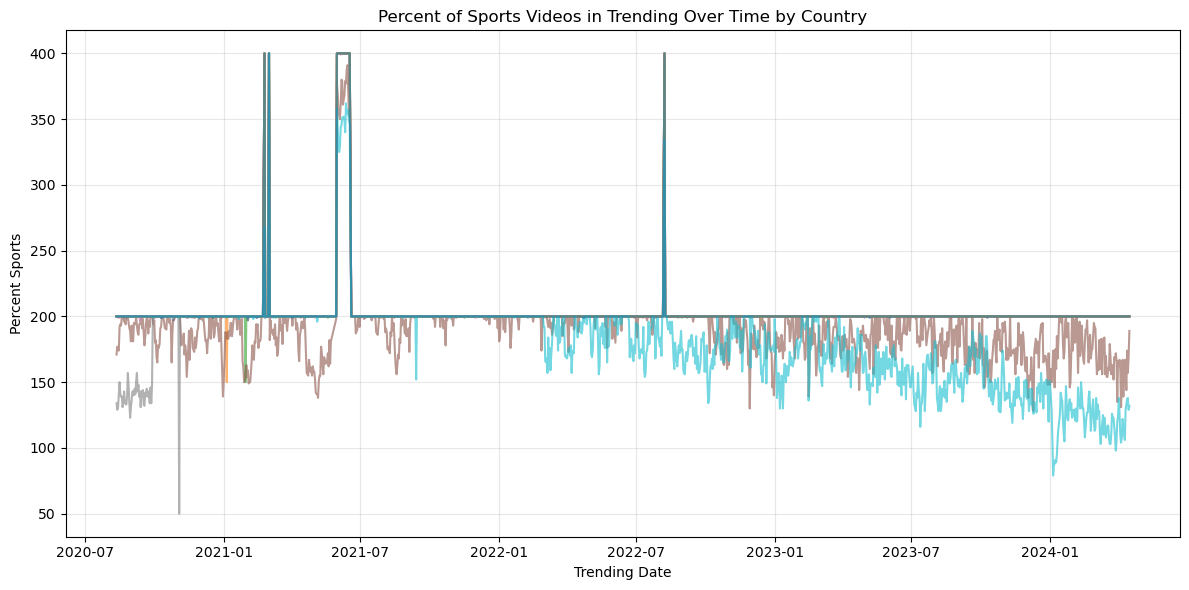

In [63]:
plt.figure(figsize=(12, 6))

# Plot one line per country
for country, group_df in data_grouped.groupby("country_code"):
    plt.plot(group_df["date_clean"], group_df["videos"], alpha=0.6)

plt.title("Percent of Sports Videos in Trending Over Time by Country")
plt.xlabel("Trending Date")
plt.ylabel("Percent Sports")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

There are spikes in Olympics-related video during the Olympics, but not as big as we might expect. Also, lots of Olympics-related videos far from an Olympics.

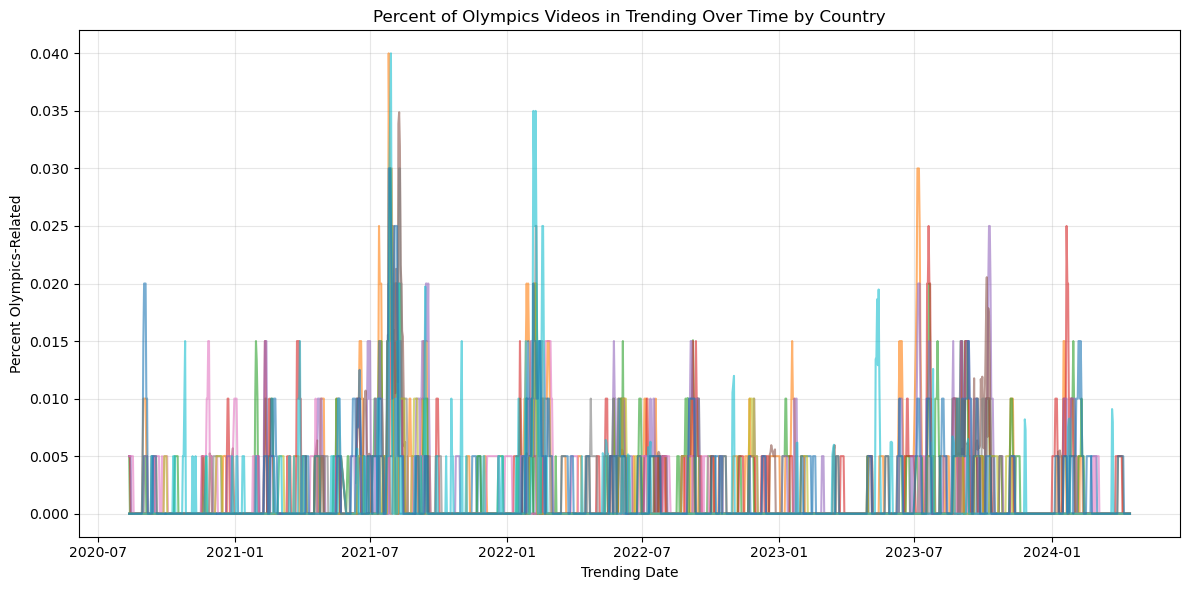

In [50]:
plt.figure(figsize=(12, 6))

# Plot one line per country
for country, group_df in data_grouped.groupby("country_code"):
    plt.plot(group_df["date_clean"], group_df["olympic_pct"], alpha=0.6)

plt.title("Percent of Olympics Videos in Trending Over Time by Country")
plt.xlabel("Trending Date")
plt.ylabel("Percent Olympics-Related")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [51]:
import kagglehub

# Download latest version
summer_path = kagglehub.dataset_download("piterfm/tokyo-2020-olympics")

winter_path = kagglehub.dataset_download("piterfm/beijing-2022-olympics")

In [10]:
os.listdir(summer_path)

['athletes.csv',
 'technical_officials.csv',
 'medals_total.csv',
 'coaches.csv',
 'medals.csv']

In [52]:
summer_medals = pd.read_csv(os.path.join(summer_path,'medals.csv'))

winter_medals = pd.read_csv(os.path.join(winter_path,'medals.csv'))

In [12]:
print(summer_medals['country_code'].unique())
print(data_grouped['country_code'].unique())
#need to crosswalk over from 3 letter labels to 2

['KOR' 'NED' 'MEX' 'ECU' 'BEL' 'SLO' 'HUN' 'ITA' 'CHN' 'ROU' 'EST' 'JPN'
 'TPE' 'FRA' 'KAZ' 'KOS' 'UKR' 'MGL' 'IRI' 'SRB' 'ROC' 'SUI' 'TUN' 'THA'
 'ESP' 'ISR' 'IND' 'INA' 'GER' 'AUT' 'CAN' 'USA' 'GEO' 'BRA' 'GBR' 'BUL'
 'AUS' 'UZB' 'TUR' 'COL' 'CZE' 'HKG' 'DEN' 'KUW' 'JOR' 'CRO' 'EGY' 'CIV'
 'NOR' 'NZL' 'PHI' 'RSA' 'MKD' 'CUB' 'BER' 'TKM' 'LAT' 'IRL' 'POL' 'FIJ'
 'ARG' 'VEN' 'POR' 'SVK' 'SMR' 'FIN' 'ETH' 'UGA' 'AZE' 'GRE' 'DOM' 'SWE'
 'JAM' 'MAS' 'BLR' 'QAT' 'ARM' 'MAR' 'KEN' 'PUR' 'NAM' 'NGR' 'GHA' 'KGZ'
 'SYR' 'BAH' 'GRN' 'BUR' 'LTU' 'BOT' 'BRN' 'MDA' 'KSA']
['BR' 'CA' 'DE' 'FR' 'GB' 'IN' 'JP' 'KR' 'MX' 'RU' 'US']


In [53]:
iso2_to_iso3 = {
    "DE": "GER",
    "FR": "FRA",
    "GB": "GBR",
    "IN": "IND",
    "JP": "JPN",
    "KR": "KOR",
    "CA": "CAN",
    "BR": "BRA",
    "US": "USA",
    "MX": "MEX",
    "RU": "RUS" 
}

data_grouped['country_code_iso3'] = data_grouped['country_code'].map(iso2_to_iso3)

#Russian Olympic Committee
summer_medals['country_code_iso3'] = summer_medals['country_code'].replace({'ROC': 'RUS'})
winter_medals['country_code_iso3'] = winter_medals['country_code'].replace({'ROC': 'RUS'})

In [54]:
clean_date(summer_medals, 'medal_date')
clean_date(winter_medals, 'medal_date')

In [55]:
#these are based on medals not opening and closing ceremony
summer_min = summer_medals['date_clean'].min()
summer_max = summer_medals['date_clean'].max()

winter_min = winter_medals['date_clean'].min()
winter_max = winter_medals['date_clean'].max()

data_grouped['olympic_period_summer'] = (
    (data_grouped['date_clean'] >= summer_min) &
    (data_grouped['date_clean'] <= summer_max)
).astype(int)

data_grouped['olympic_period_winter'] = (
    (data_grouped['date_clean'] >= winter_min) &
    (data_grouped['date_clean'] <= winter_max)
).astype(int)

data_grouped['olympic_period'] = data_grouped['olympic_period_summer'] + data_grouped['olympic_period_winter']

In [66]:
data_grouped["event_time_summer"] = (
    data_grouped["date_clean"] - summer_min
).dt.days

data_grouped["event_time_winter"] = (
    data_grouped["date_clean"] - winter_min
).dt.days

WINDOW = 30  # ±30 days

summer_event = data_grouped[
    data_grouped["event_time_summer"].between(-WINDOW, WINDOW)
]

winter_event = data_grouped[
    data_grouped["event_time_winter"].between(-WINDOW, WINDOW)
]

summer_avg = (
    summer_event
        .groupby("event_time_summer")["sports_pct"]
        .mean()
        .reset_index()
)

winter_avg = (
    winter_event
        .groupby("event_time_winter")["sports_pct"]
        .mean()
        .reset_index()
)


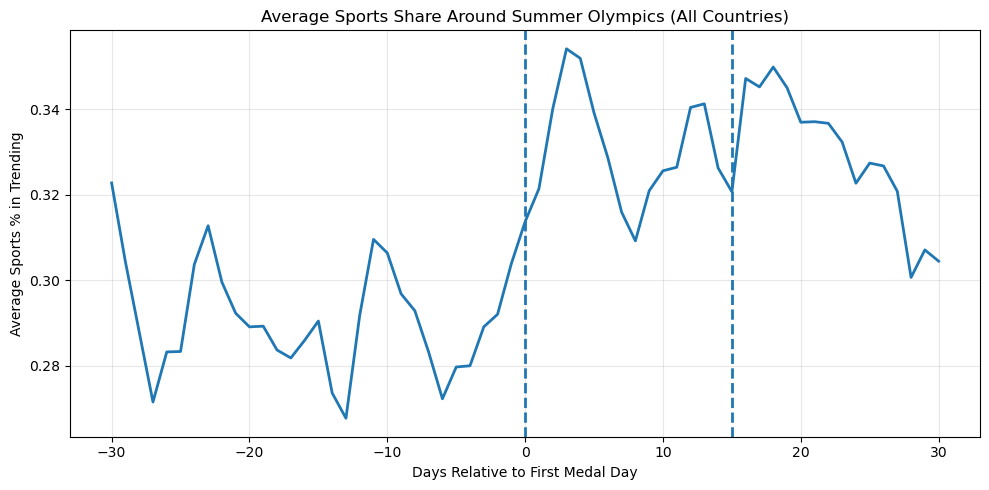

In [67]:
plt.figure(figsize=(10, 5))

plt.plot(
    summer_avg["event_time_summer"],
    summer_avg["sports_pct"],
    linewidth=2
)

# Mark first & last day
plt.axvline(0, linestyle="--", linewidth=2)
plt.axvline((summer_max - summer_min).days, linestyle="--", linewidth=2)

plt.title("Average Sports Share Around Summer Olympics (All Countries)")
plt.xlabel("Days Relative to First Medal Day")
plt.ylabel("Average Sports % in Trending")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


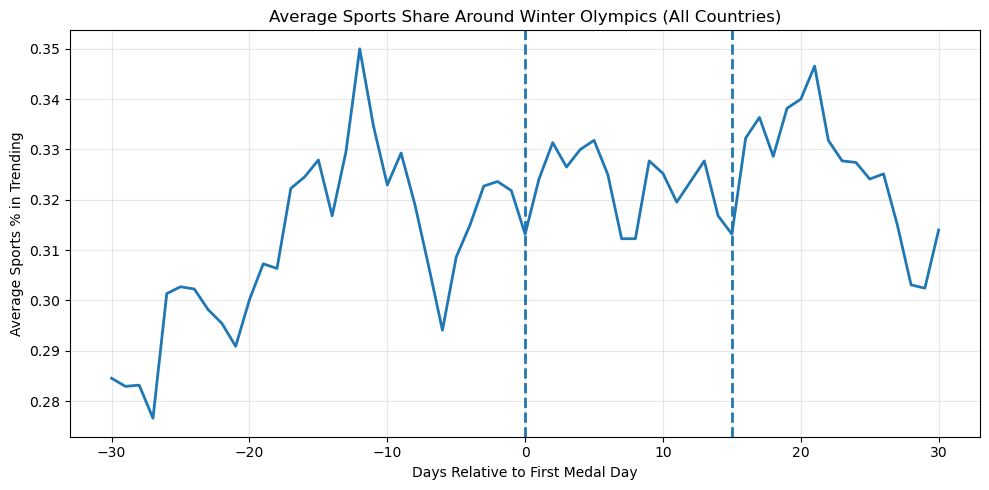

In [68]:
plt.figure(figsize=(10, 5))

plt.plot(
    winter_avg["event_time_winter"],
    winter_avg["sports_pct"],
    linewidth=2
)

# Mark first & last day
plt.axvline(0, linestyle="--", linewidth=2)
plt.axvline((winter_max - winter_min).days, linestyle="--", linewidth=2)

plt.title("Average Sports Share Around Winter Olympics (All Countries)")
plt.xlabel("Days Relative to First Medal Day")
plt.ylabel("Average Sports % in Trending")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [56]:
def create_week_window(df, start_date, end_date, weeks_before=0, weeks_after=0, prefix='summer'):
    """
    Creates dummies for weeks before, during, and after an event.
    
    weeks_before: number of weeks prior to start_date to create dummy
    weeks_after: number of weeks after end_date to create dummy
    prefix: string to label the dummy columns
    """
    df = df.copy()
    
    # Weeks before
    for w in range(1, weeks_before + 1):
        col = f'{prefix}_week_minus_{w}'
        df[col] = ((df['date_clean'] >= (start_date - pd.Timedelta(weeks=w))) &
                   (df['date_clean'] < start_date)).astype(int)
    
    # During Olympics
    df[f'{prefix}_during'] = ((df['date_clean'] >= start_date) &
                              (df['date_clean'] <= end_date)).astype(int)
    
    # Weeks after
    for w in [2, 4]:  # as you specified
        col = f'{prefix}_week_plus_{w}'
        df[col] = ((df['date_clean'] > end_date) &
                   (df['date_clean'] <= end_date + pd.Timedelta(weeks=w))).astype(int)
    
    return df

# Apply for Summer Olympics
data_grouped = create_week_window(data_grouped, summer_min, summer_max, weeks_before=1, prefix='summer')

# Apply for Winter Olympics
data_grouped = create_week_window(data_grouped, winter_min, winter_max, weeks_before=1, prefix='winter')


Estimate medal effects seperately by country - Russia may have an especially low effect for this because their team didn't officially compete

In [57]:
medals = pd.concat([summer_medals, winter_medals], ignore_index=True)
medals['gold']   = (medals['medal_code'] == 1).astype(int)
medals['silver'] = (medals['medal_code'] == 2).astype(int)
medals['bronze'] = (medals['medal_code'] == 3).astype(int)

daily_medals = (
    medals.groupby(['date_clean', 'country_code_iso3'])
          .agg({
              'gold': 'sum',
              'silver': 'sum',
              'bronze': 'sum'
          })
          .reset_index()
)

data_grouped = data_grouped.merge(
    daily_medals,
    left_on=['date_clean', 'country_code_iso3'],
    right_on=['date_clean', 'country_code_iso3'],
    how='left'
)

data_grouped[['gold', 'silver', 'bronze']] = data_grouped[['gold', 'silver', 'bronze']].fillna(0)

In [58]:
data_grouped['medal_count'] = data_grouped['gold'] + data_grouped['silver'] + data_grouped['bronze']
data_grouped['medal_score'] = 3*data_grouped['gold'] + 2*data_grouped['silver'] + data_grouped['bronze']

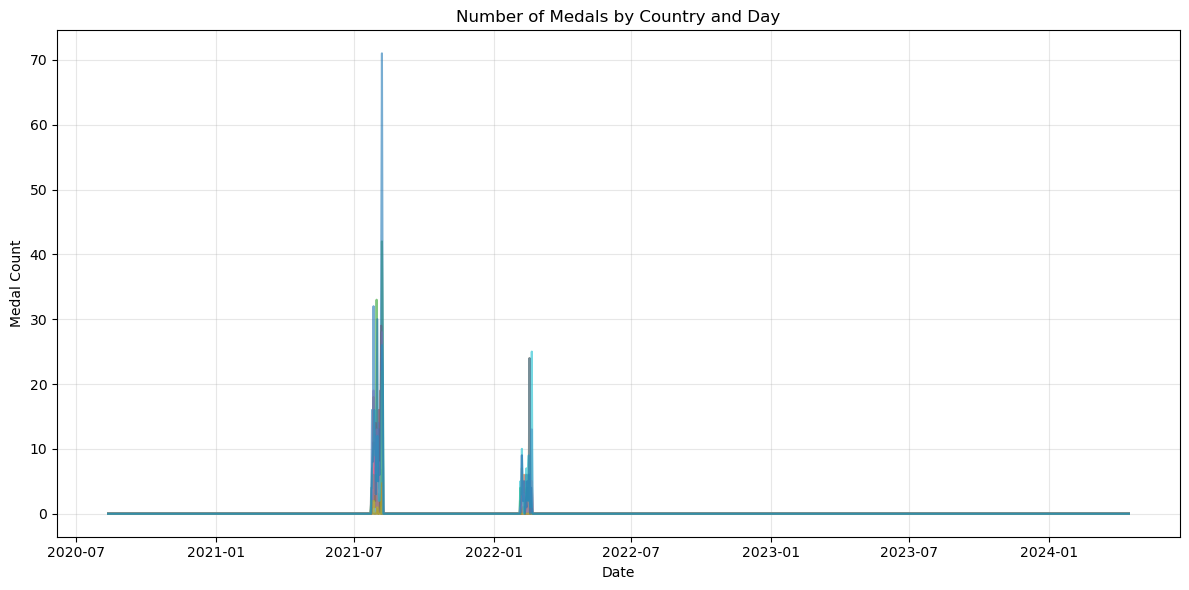

In [59]:
plt.figure(figsize=(12, 6))

for country, group_df in data_grouped.groupby("country_code_iso3"):
    plt.plot(group_df["date_clean"], group_df["medal_count"], alpha=0.6)

plt.title("Number of Medals by Country and Day")
plt.xlabel("Date")
plt.ylabel("Medal Count")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
data_grouped['sports_videos'].var(), data_grouped['sports_videos'].mean()

(395.3864570393661, 63.72423034634414)

Variance(y) >> Mean(y)
Thus, the data are overdispersed and negative binomial is more appropriate than Poisson

I tried to estimate alpha in E(Y|X) = mu + alpha*mu^2 using discrete NB but it didn't work, probably due to having too many fixed effects. Thus, I am using an implementaiton where alpha = 1 with robust SEs.

Base Model

In [62]:
model = smf.glm(
    formula="sports_videos ~ olympic_period + C(country_code_iso3) + date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14552
Model:                            GLM   Df Residuals:                    14528
Model Family:        NegativeBinomial   Df Model:                           23
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74354.
Date:                Sat, 13 Dec 2025   Deviance:                       334.92
Time:                        19:49:46   Pearson chi2:                     321.
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08295
Covariance Type:                  HC3                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


In [24]:
data_grouped['country_code_iso3'].unique() #Brazil is the reference group

array(['BRA', 'CAN', 'GER', 'FRA', 'GBR', 'IND', 'JPN', 'KOR', 'MEX',
       'RUS', 'USA'], dtype=object)

Is time trend different by country?

In [25]:
model = smf.glm(
    formula="sports_videos ~ olympic_period + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14467
Model:                            GLM   Df Residuals:                    14433
Model Family:        NegativeBinomial   Df Model:                           33
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46323.
Date:                Sat, 13 Dec 2025   Deviance:                       2074.2
Time:                        18:40:55   Pearson chi2:                 1.62e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08334
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Are summer and winter olympic effects different?

In [26]:
model = smf.glm(
    formula="sports_videos ~ olympic_period_summer + olympic_period_winter + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())
#Yes, summer effect is larger

                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14467
Model:                            GLM   Df Residuals:                    14432
Model Family:        NegativeBinomial   Df Model:                           34
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46323.
Date:                Sat, 13 Dec 2025   Deviance:                       2073.8
Time:                        18:41:15   Pearson chi2:                 1.62e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08336
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Pre and post Olympic effects

In [44]:
model = smf.glm(
    formula="sports_videos ~ summer_week_minus_1 + summer_during + summer_week_plus_2 + summer_week_plus_4 + winter_week_minus_1 + winter_during + winter_week_plus_2 + winter_week_plus_4 + medal_count + medal_count_lag1 + medal_count_lag2 + medal_count_lag3 + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14390
Model:                            GLM   Df Residuals:                    14345
Model Family:        NegativeBinomial   Df Model:                           44
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46047.
Date:                Sat, 13 Dec 2025   Deviance:                       2064.0
Time:                        19:20:06   Pearson chi2:                 1.61e+03
No. Iterations:                     7   Pseudo R-squ. (CS):            0.08340
Covariance Type:                  HC3                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Are Olympic Period effects different by country?

In [28]:
model = smf.glm(
    formula="sports_videos ~ C(country_code_iso3) * olympic_period_winter + C(country_code_iso3) * olympic_period_summer + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")
print(model.summary())
#There is quite strong heterogeneity in summer/winter olympic effects between countries

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


                 Generalized Linear Model Regression Results                  
Dep. Variable:          sports_videos   No. Observations:                14467
Model:                            GLM   Df Residuals:                    14412
Model Family:        NegativeBinomial   Df Model:                           54
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -46320.
Date:                Sat, 13 Dec 2025   Deviance:                       2068.6
Time:                        18:42:00   Pearson chi2:                 1.62e+03
No. Iterations:                     6   Pseudo R-squ. (CS):            0.08369
Covariance Type:                  HC3                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

Is medal count or medal score a better predictor?

In [29]:
model = smf.glm(
    formula="sports_videos ~ medal_count + C(country_code_iso3) * olympic_period_winter + C(country_code_iso3) * olympic_period_summer + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")

coef_medal_count = model.params["medal_count"]
se_medal_count   = model.bse["medal_count"]

model = smf.glm(
    formula="sports_videos ~ medal_score + C(country_code_iso3) * olympic_period_winter + C(country_code_iso3) * olympic_period_summer + C(country_code_iso3) * date_num + C(month)",
    data=data_grouped,
    family=sm.families.NegativeBinomial(),
    offset=np.log(data_grouped["videos"])
).fit(cov_type="HC3")

coef_medal_score = model.params["medal_score"]
se_medal_score   = model.bse["medal_score"]

print("Medal Count:", coef_medal_count, "SE:", se_medal_count)
print("Medal Score:", coef_medal_score, "SE:", se_medal_score)
#Neither are even close to significant, proceeding with medal_count because it at least has a positive estimate

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Medal Count: 0.002479185970486397 SE: 0.002856815863078967
Medal Score: 0.0008574075894435008 SE: 0.0012888352368474896


What about lagged medal count?

In [30]:
data_grouped = data_grouped.sort_values(["country_code", "date_clean"])

for l in range(1, 8):  # 1 to 7
    data_grouped[f"medal_count_lag{l}"] = (
        data_grouped.groupby("country_code")["medal_count"].shift(l)
    )

lag_cols = [f"medal_count_lag{l}" for l in range(1, 8)]
data_grouped[lag_cols] = data_grouped[lag_cols].fillna(0)

for t in range(1, 22): # 1 (medal_count) to 21
    data_grouped[f"rolling_medals_{t}"] = (
        data_grouped.groupby("country_code")["medal_count"]
        .rolling(t, min_periods=1)
        .sum()
        .reset_index(0, drop=True)
    )
#rolling sum

In [31]:
data_grouped[[f"rolling_medals_{t}" for t in range(1, 22)]].isna().sum()
#no NAs

rolling_medals_1     0
rolling_medals_2     0
rolling_medals_3     0
rolling_medals_4     0
rolling_medals_5     0
rolling_medals_6     0
rolling_medals_7     0
rolling_medals_8     0
rolling_medals_9     0
rolling_medals_10    0
rolling_medals_11    0
rolling_medals_12    0
rolling_medals_13    0
rolling_medals_14    0
rolling_medals_15    0
rolling_medals_16    0
rolling_medals_17    0
rolling_medals_18    0
rolling_medals_19    0
rolling_medals_20    0
rolling_medals_21    0
dtype: int64

In [42]:
results = []

for t in range(1, 22):
    var = f"rolling_medals_{t}"
    
    formula = (
        f"sports_videos ~ {var} + summer_week_minus_1 + summer_during + summer_week_plus_2 + summer_week_plus_4 + winter_week_minus_1 + winter_during + winter_week_plus_2 + winter_week_plus_4 + C(country_code_iso3) * date_num + C(month)"
    )
    
    model = smf.glm(
        formula=formula,
        data=data_grouped,
        family=sm.families.NegativeBinomial(),
        offset=np.log(data_grouped["videos"])
    ).fit(cov_type="HC3")
    
    z_val = model.tvalues[var]
    coef  = model.params[var]
    
    results.append({
        "rolling_window": t,
        "coef": coef,
        "z_value": z_val
    })

z_df = pd.DataFrame(results)

/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/opt/anaconda3/envs/py3.12.3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alp

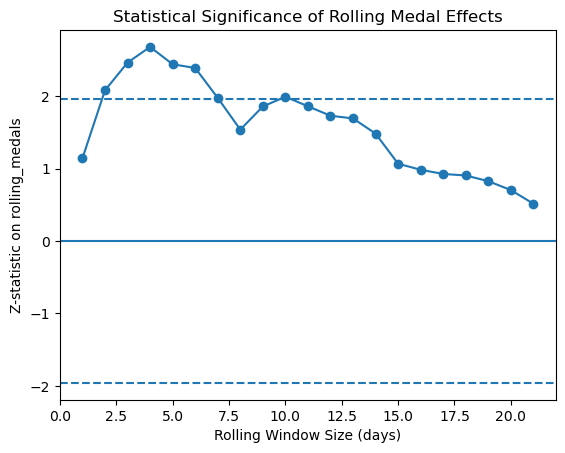

In [43]:
plt.figure()
plt.plot(z_df["rolling_window"], z_df["z_value"], marker="o")
plt.axhline(0)
plt.axhline(1.96, linestyle="--")
plt.axhline(-1.96, linestyle="--")

plt.xlabel("Rolling Window Size (days)")
plt.ylabel("Z-statistic on rolling_medals")
plt.title("Statistical Significance of Rolling Medal Effects")

plt.show()


In [36]:
print(z_df)

   rolling_window      coef   z_value
0               1  0.005306  2.311515
1               2  0.005134  1.982652
2               3  0.004110  1.684137
3               4  0.001533  0.811128
4               5  0.001619  0.871578
5               6 -0.001142 -0.428414
6               7 -0.002916 -1.499354


Estimating effect sizes in terms of videos

In [37]:
np.mean(data_grouped['videos'])

33.79249326052395

/var/folders/s0/l3pnrz5d5fq7ntypk3t_b3fc0000gn/T/ipykernel_14036/3391486068.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.iloc[7:])


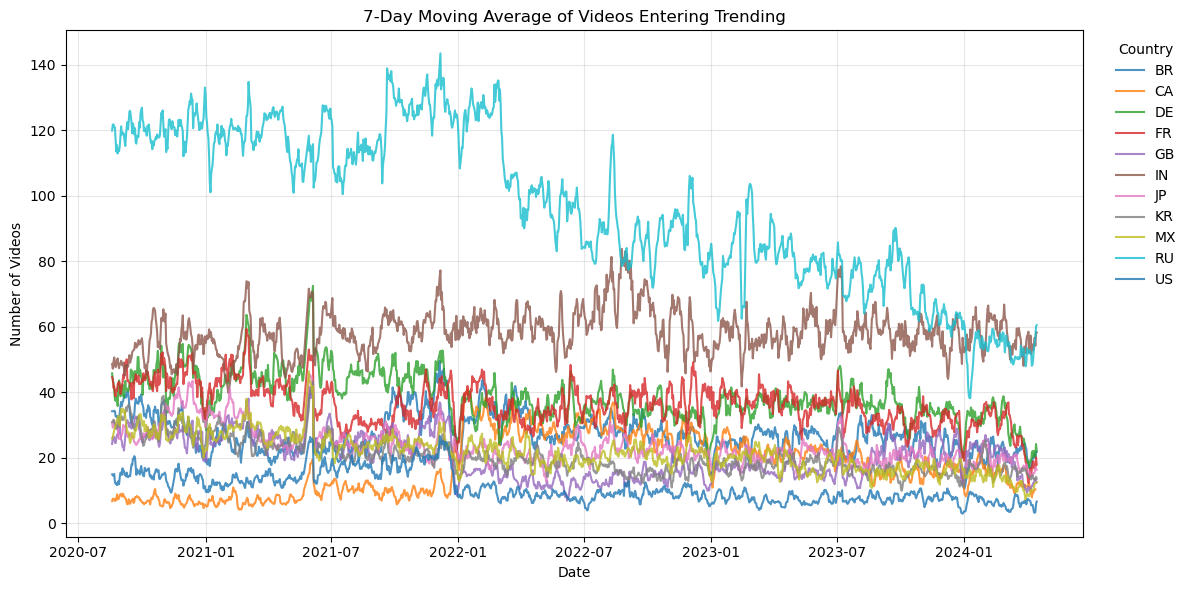

In [ ]:
# make sure data are sorted
data_grouped = data_grouped.sort_values(["country_code", "date_clean"])

# 7-day moving average by country
data_grouped["videos_ma7"] = (
    data_grouped
        .groupby("country_code")["videos"]
        .transform(lambda x: x.rolling(window=7, min_periods=1).mean())
)

plt.figure(figsize=(12, 6))

for country, group_df in data_grouped.groupby("country_code"):
    plt.plot(
        group_df["date_clean"],
        group_df["videos_ma7"],
        alpha=0.8,
        label=country
    )

plt.title("7-Day Moving Average of Videos Entering Trending")
plt.xlabel("Date")
plt.ylabel("Number of Videos")
plt.grid(True, alpha=0.3)

plt.legend(
    title="Country",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False
)

plt.tight_layout()
plt.show()
